# Stock Market Prediction using Numerical and Textual Analysis 
### (Using Stacked LSTM)
#### Datasets used
- Historical stock prices: https://finance.yahoo.com/ <br>
- Textual News Headlines: https://bit.ly/36fFPI6

## 1 Downloading Datasets | Stock Price Data | Stock News Headlines Data

In [1]:
# download nltk if not installed previously
# nltk.download('vader_lexicon')

In [2]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
# reading the datasets into pandas
stock_price = pd.read_csv('AAPL.csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [4]:
# displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200


In [5]:
# displaying stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


## 2 Feature Engineering

In [6]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(4904, 3297172)

In [7]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

### 2.1 Stock Price Data

In [8]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200
...,...,...,...,...,...
2020-06-24,90.014999,91.250000,92.197502,89.629997,192623200
2020-06-25,91.209999,90.175003,91.250000,89.392502,137522400
2020-06-26,88.407501,91.102501,91.330002,88.254997,205256800


### 2.2 Stock News Headlines Data

In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


### 2.3 Combined Stock Data

In [10]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-06-24,90.014999,91.250000,92.197502,89.629997,192623200.0,I never thought I had a voice until today: Vid...
2020-06-25,91.209999,90.175003,91.250000,89.392502,137522400.0,Truck firms look for new export markets to sel...
2020-06-26,88.407501,91.102501,91.330002,88.254997,205256800.0,Containment zone residents slam high prices ch...
2020-06-29,90.445000,88.312500,90.542503,87.820000,130646000.0,6 hot and stylish bikini looks of Katrina Kaif...


### 2.4 Calculating Sentiment Scores

In [11]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,,,,
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [12]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


## 3 Finalising Stock Data and writing to Disk

In [13]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9032,0.105,0.746,0.149,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


In [14]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

## 4 Reading Stock Data 

In [15]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9032,0.105,0.746,0.149,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


## 5 Feature Engineering of Stock Data

In [16]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4877, 9)

In [17]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [18]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4.877000e+03
mean,17.237386,-0.870185,0.125720,0.788116,0.086175,17.228087,17.402949,17.056717,4.513386e+08
std,18.701168,0.453365,0.024431,0.033153,0.020881,18.670832,18.873534,18.499968,3.855476e+08
min,0.234286,-1.000000,0.000000,0.000000,0.000000,0.231964,0.235536,0.227143,3.247000e+07
25%,2.132857,-0.999800,0.112000,0.768000,0.075000,2.136429,2.165357,2.096071,1.774640e+08
50%,10.901428,-0.999000,0.127000,0.785000,0.086000,10.900000,11.000000,10.746428,3.374672e+08
75%,27.350000,-0.994100,0.141000,0.806000,0.096000,27.334999,27.605000,27.100000,6.051080e+08
max,91.632500,1.000000,0.444000,1.000000,0.608000,91.250000,93.095001,90.567497,3.372970e+09


In [19]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4877 entries, 2001-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4877 non-null   float64
 1   compound  4877 non-null   float64
 2   negative  4877 non-null   float64
 3   neutral   4877 non-null   float64
 4   positive  4877 non-null   float64
 5   Open      4877 non-null   float64
 6   High      4877 non-null   float64
 7   Low       4877 non-null   float64
 8   Volume    4877 non-null   float64
dtypes: float64(9)
memory usage: 381.0+ KB


## 6 EDA of Stock Data

Text(0, 0.5, 'Close Price ($)')

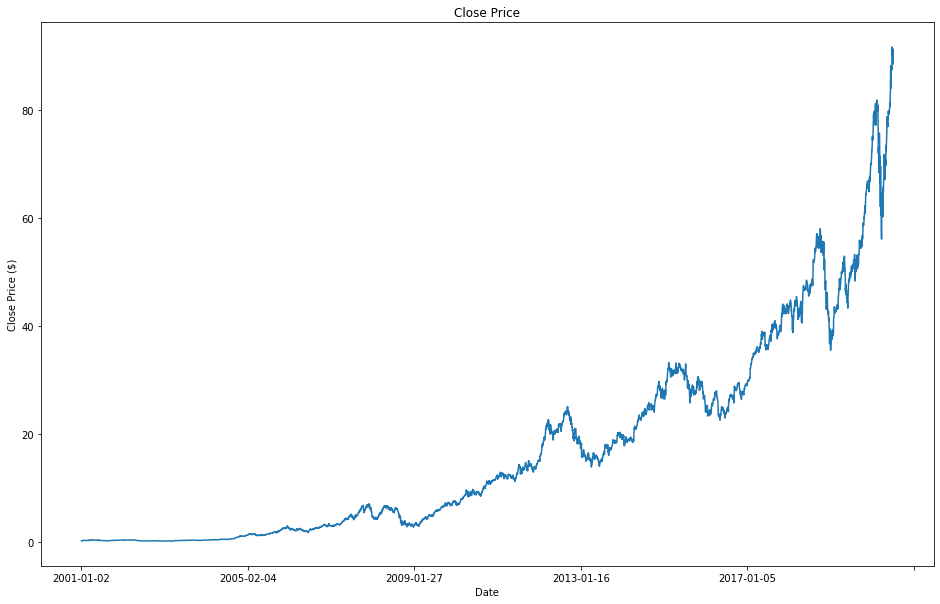

In [20]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [21]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293368,-0.179071,0.121714,0.810429,0.067571,0.293088,0.304687,0.281728,566364000.0
2001-01-11,0.301340,-0.041629,0.117857,0.810286,0.071571,0.296596,0.312978,0.286033,616567200.0
2001-01-23,0.311862,0.000843,0.111000,0.818429,0.070429,0.308873,0.323820,0.297832,625489600.0


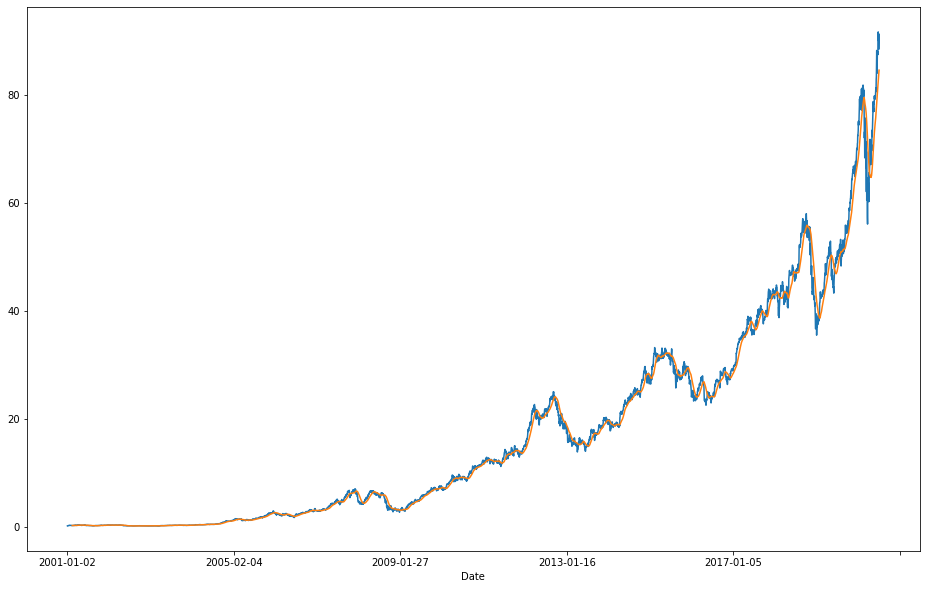

In [22]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [23]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9032,0.105,0.746,0.149,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
...,...,...,...,...,...,...,...,...,...
2020-06-24,90.014999,-0.9997,0.115,0.811,0.074,91.250000,92.197502,89.629997,192623200.0
2020-06-25,91.209999,-0.9999,0.126,0.820,0.054,90.175003,91.250000,89.392502,137522400.0
2020-06-26,88.407501,-0.9999,0.149,0.766,0.085,91.102501,91.330002,88.254997,205256800.0


## 7 Data Preparation for Modelling

In [24]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3900
Number of records in Test Data: 977


In [25]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03     0.292411
2001-01-04     0.304688
2001-01-05     0.292411
2001-01-08     0.295759
2001-01-09     0.306920
                ...    
2020-06-24    90.014999
2020-06-25    91.209999
2020-06-26    88.407501
2020-06-29    90.445000
2020-06-30    91.199997
Name: Close, Length: 4876, dtype: float64

In [26]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,0.292411,0.304688,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.292411,0.6648,0.9032,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.295759,0.9032,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,0.306920,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,0.295759,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
2001-01-10,0.295759,0.321429,-0.5719,0.0000,580781600.0,0.297991,0.303571,0.286830
2001-01-11,0.321429,0.366071,0.0000,0.9295,803734400.0,0.290179,0.330357,0.290179
2001-01-23,0.366071,0.366071,0.9295,-0.9039,879530400.0,0.344866,0.373884,0.340402
2001-01-24,0.366071,0.356027,-0.9039,-0.9854,717091200.0,0.368304,0.369420,0.349330


## 8 Setting the Target Variable and the Feature Dataset

In [27]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-03     0.304688
2001-01-04     0.292411
2001-01-05     0.295759
2001-01-08     0.306920
2001-01-09     0.295759
                ...    
2020-06-23    90.014999
2020-06-24    91.209999
2020-06-25    88.407501
2020-06-26    90.445000
2020-06-29    91.199997
Name: close_price_shifted, Length: 4875, dtype: float64

In [28]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,0.292411,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.6648,0.9032,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.9032,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
...,...,...,...,...,...,...,...
2020-06-23,91.632500,-0.9999,-0.9997,212155600.0,91.000000,93.095001,90.567497
2020-06-24,90.014999,-0.9997,-0.9999,192623200.0,91.250000,92.197502,89.629997
2020-06-25,91.209999,-0.9999,-0.9999,137522400.0,90.175003,91.250000,89.392502


### 8.1 Scaling the Target Variable and the Feature Dataset
Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [29]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99872809,  0.6322    ,  0.6648    , ..., -0.99940748,
         -0.99865485, -0.99932101],
        [-0.99845944,  0.6648    ,  0.9032    , ..., -0.99797895,
         -0.99795775, -0.99838212],
        [-0.99872809,  0.9032    , -0.9638    , ..., -0.99845105,
         -0.99839043, -0.99867862],
        ...,
        [ 0.99075472, -0.9999    , -0.9999    , ...,  0.97637837,
          0.96026251,  0.97398737],
        [ 0.92942972, -0.9999    , -0.9997    , ...,  0.99675891,
          0.96198559,  0.94880472],
        [ 0.97401481, -0.9997    , -0.9998    , ...,  0.93545235,
          0.94502449,  0.93917454]]),
 array([[-0.99845944],
        [-0.99872809],
        [-0.99865483],
        ...,
        [ 0.92942972],
        [ 0.97401481],
        [ 0.99053585]]))

### 8.2 Dividing the dataset into Training and Test
Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [30]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3900, 7) and y: (3900, 1)
Number of rows and columns in the Test set X: (974, 7) and y: (974, 1)


### 8.3 Reshaping the Feature Dataset

In [31]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3900, 7, 1)
Shape of Test set X: (974, 7, 1)


## 9 Stock Data Modelling

In [32]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
________________________________________________

In [33]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 14s 4ms/step - loss: 0.0335 - val_loss: 0.1489
Epoch 2/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.0090 - val_loss: 0.0014
Epoch 3/10
3120/3120 [==============================] - 12s 4ms/step - loss: 0.0025 - val_loss: 3.4762e-04
Epoch 4/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.0021 - val_loss: 8.7089e-04
Epoch 5/10
3120/3120 [==============================] - 14s 4ms/step - loss: 0.0020 - val_loss: 8.4524e-04
Epoch 6/10
3120/3120 [==============================] - 14s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/10
3120/3120 [==============================] - 14s 5ms/step - loss: 0.0015 - val_loss: 2.2926e-04
Epoch 8/10
3120/3120 [==============================] - 14s 5ms/step - loss: 0.0012 - val_loss: 3.0356e-04
Epoch 9/10
3120/3120 [==============================] - 15s 5

### 9.1 Saving the Model to disk

In [34]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


## 10 Predictions

In [35]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[27.534704],
       [27.351366],
       [27.448437],
       [27.37178 ],
       [27.2595  ]], dtype=float32)

## 11 Model Evaluation

In [36]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

974/974 [==============================] - 18s 19ms/step
Train Loss = 0.0002
Test Loss = 0.001


In [37]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 50.3044


In [38]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 50.3044


## 12 Plotting the Predictions against unseen data

In [39]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

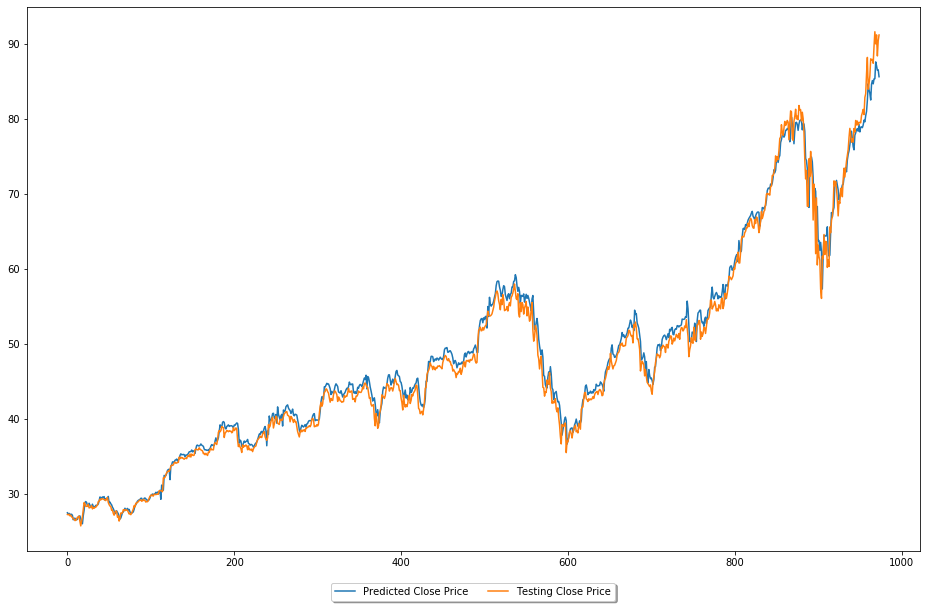

In [40]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()